In [2]:
import folium
from tqdm import tqdm
import math
from scripts import *
from utils import *

import os
import numpy as np
import datetime
import os
import matplotlib.pyplot as plt
import cv2
import ee


In [3]:
grid = 1
box_dim = 5 # km
min_lat, min_lon  = 33.23119, 75.18916
start_date = "2024-05-01"
end_date = "2024-05-06"
project_name = 'Pernote'
os.makedirs(project_name, exist_ok=True)

In [ ]:
# grid = 1
# box_dim = 5 # km
# min_lat, min_lon  = 12.98239, 80.14702
# start_date = "2024-04-19"
# end_date = "2024-05-24"
# project_name = 'Chennai Airport'
# os.makedirs(project_name, exist_ok=True)

In [4]:
g = generate_grid(min_lat, min_lon, distance=box_dim*1000, grid_side=grid)

m = folium.Map(
    location=(min_lat, min_lon),
    zoom_start=15,
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri'
)
for i in range(len(g)):
    folium.Rectangle([(g[i][:2]), (g[i][2:])], color='red', fill='pink',fill_opcity=0.5).add_to(m)

m

In [5]:
NDVI_Before = get_images(km=box_dim, grid=g, grid_dim=grid, script=evalscript_NDVI, 
           date_start=start_date, date_end=start_date, res=1000, 
           box_dim=box_dim, file_name=f"{project_name}/{project_name}-NDVI-Before")

NDVI_After = get_images(km=box_dim, grid=g, grid_dim=grid, script=evalscript_NDVI, 
           date_start=end_date, date_end=end_date, res=1000, 
           box_dim=box_dim, file_name=f"{project_name}/{project_name}-NDVI-After")

True_Color_After = get_images(km=box_dim, grid=g, grid_dim=grid, script=evalscript_True_Color, 
           date_start=end_date, date_end=end_date, res=1000, 
           box_dim=box_dim, file_name=f"{project_name}/{project_name}-True_Color-After")

LSM_Only_After = get_images(km=box_dim, grid=g, grid_dim=grid, script=evalscript_lsm_only, 
           date_start=end_date, date_end=end_date, res=1000, 
           box_dim=box_dim, file_name=f"{project_name}/{project_name}-LSM_Only-After")

mask = cv2.GaussianBlur((cv2.cvtColor(NDVI_After, cv2.COLOR_RGB2GRAY) < cv2.cvtColor(NDVI_Before, cv2.COLOR_RGB2GRAY)).astype(np.uint8) * 255, (7, 7), 0)


0 0 [33.23119, 75.18916, 33.276156080295934, 75.24291720494928] -> 0 1000 0 1000
Saved: Pernote/Pernote-NDVI-Before.png
----
0 0 [33.23119, 75.18916, 33.276156080295934, 75.24291720494928] -> 0 1000 0 1000
Saved: Pernote/Pernote-NDVI-After.png
----
0 0 [33.23119, 75.18916, 33.276156080295934, 75.24291720494928] -> 0 1000 0 1000
Saved: Pernote/Pernote-True_Color-After.png
----
0 0 [33.23119, 75.18916, 33.276156080295934, 75.24291720494928] -> 0 1000 0 1000
Saved: Pernote/Pernote-LSM_Only-After.png
----


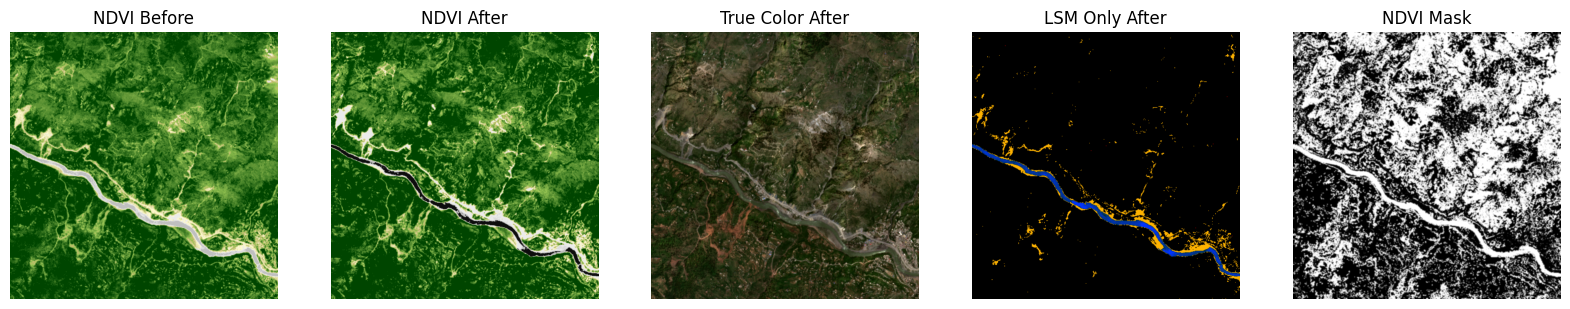

In [6]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 5, 1)
plt.title("NDVI Before")
plt.imshow(NDVI_Before); plt.axis("off")

plt.subplot(1, 5, 2)
plt.title("NDVI After")
plt.imshow(NDVI_After); plt.axis("off")

plt.subplot(1, 5, 3)
plt.title("True Color After")
plt.imshow(True_Color_After); plt.axis("off")

plt.subplot(1, 5, 4)
plt.title("LSM Only After")
plt.imshow(LSM_Only_After); plt.axis("off")

plt.subplot(1, 5, 5)
plt.title("NDVI Mask")
plt.imshow(mask, cmap='gray'); plt.axis("off")

plt.show()

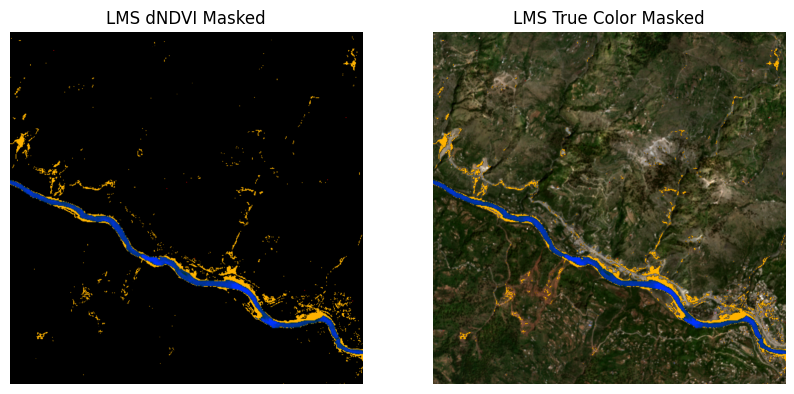

In [9]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.title("LMS dNDVI Masked")
LMS_dNDVI_Masked = combine_images_based_on_mask(LSM_Only_After, np.zeros(True_Color_After.shape) , mask, threshold=0, blur=1).astype(np.uint8)
plt.imshow(LMS_dNDVI_Masked); plt.axis("off")
plt.imsave(f"{project_name}/{project_name}-LMS_dNDVI_Masked.png", LMS_dNDVI_Masked)

plt.subplot(1, 2, 2)
plt.title("LMS True Color Masked")
bw_image = cv2.threshold(cv2.cvtColor(LMS_dNDVI_Masked, cv2.COLOR_RGB2GRAY), 0, 1, cv2.THRESH_BINARY)[1]
LMS_True_Color_dNDVI_Masked = combine_images_based_on_mask(LMS_dNDVI_Masked, True_Color_After, bw_image, threshold=0, blur=1).astype(np.uint8)
plt.imshow(LMS_True_Color_dNDVI_Masked); plt.axis("off")
plt.imsave(f"{project_name}/{project_name}-LMS_True_Color_dNDVI_Masked.png", LMS_True_Color_dNDVI_Masked)

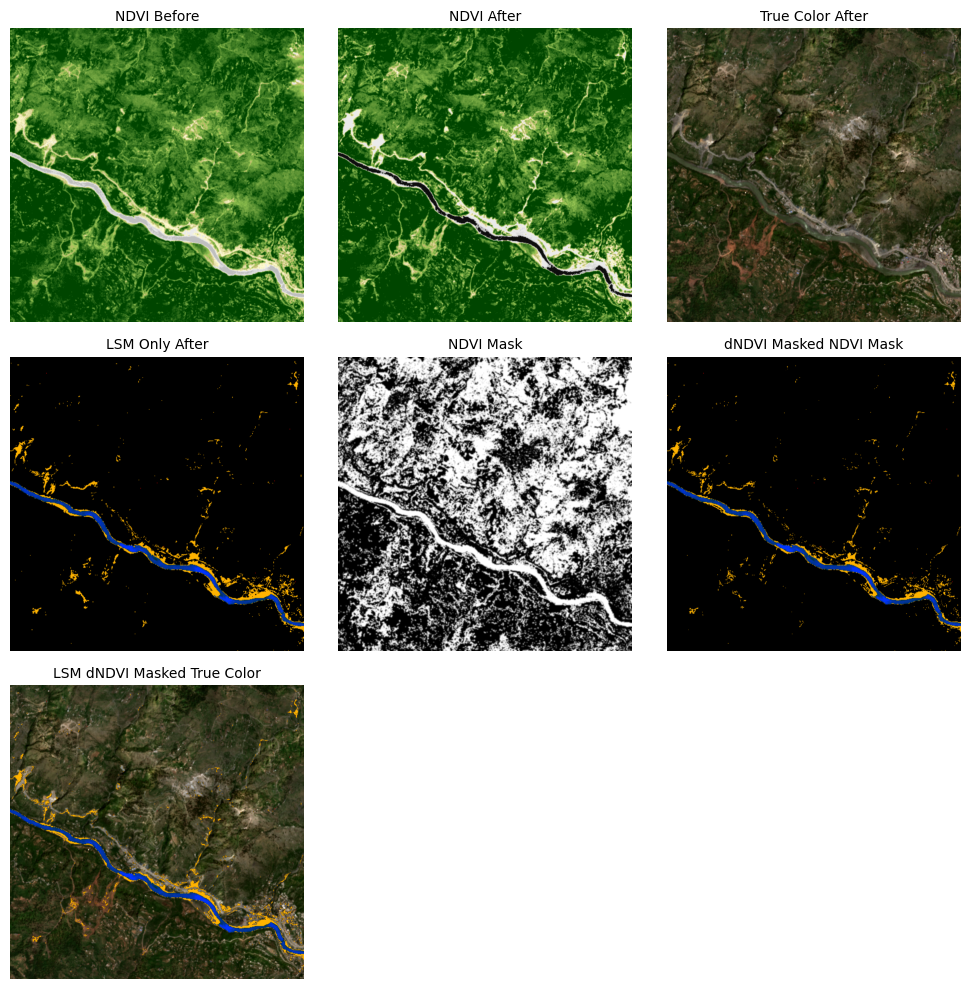

In [10]:
plt.figure(figsize=(10, 10))

fontsize = 10

plt.subplot(3, 3, 1)
plt.title("NDVI Before", fontsize=fontsize)
plt.imshow(NDVI_Before); plt.axis("off")

plt.subplot(3, 3, 2)
plt.title("NDVI After", fontsize=fontsize)
plt.imshow(NDVI_After); plt.axis("off")

plt.subplot(3, 3, 3)
plt.title("True Color After", fontsize=fontsize)
plt.imshow(True_Color_After); plt.axis("off")

plt.subplot(3, 3, 4)
plt.title("LSM Only After", fontsize=fontsize)
plt.imshow(LSM_Only_After); plt.axis("off")

plt.subplot(3, 3, 5)
plt.title("NDVI Mask", fontsize=fontsize)
plt.imshow(mask, cmap='gray'); plt.axis("off")

plt.subplot(3, 3, 6)
plt.title("dNDVI Masked NDVI Mask", fontsize=fontsize)
plt.imshow(LMS_dNDVI_Masked); plt.axis("off")

plt.subplot(3, 3, 7)
plt.title("LSM dNDVI Masked True Color", fontsize=fontsize)
plt.imshow(LMS_True_Color_dNDVI_Masked); plt.axis("off")

plt.tight_layout()
plt.savefig(f'{project_name}/combined_image.png', bbox_inches='tight', dpi=300)
plt.show()